# Modelowanie Deep Learning (MLP – klasyfikacja Credit Score)

Celem tego etapu jest zastosowanie modeli typu **Deep Learning (MLP – Multilayer Perceptron)** do wieloklasowej klasyfikacji zmiennej **`Credit_Score`** oraz porównanie ich jakości z klasycznymi modelami ML z poprzedniego notebooka.

Notebook wykorzystuje dane przygotowane w etapie preprocessingu (**`train_clean.csv`**). Dane wejściowe są przekształcane do w pełni numerycznej postaci w ramach pipeline’u:
- **standaryzacja cech numerycznych** (StandardScaler),
- **kodowanie cech kategorycznych** (One-Hot Encoding),
co jest wymagane przez modele sieci neuronowych.

W ramach analizy:
- porównano kilka architektur MLP o różnej liczbie i głębokości warstw ukrytych,
- zastosowano mechanizm **`early_stopping`** w celu ograniczenia przeuczenia,
- oceniono modele na zbiorze walidacyjnym przy użyciu **macro F1-score** (lepsze dla niezbalansowanych klas).

Na końcu wyniki zestawiono z najlepszymi rezultatami klasycznych modeli ML, aby ocenić zasadność użycia MLP dla danych tablicowych o wysokiej wymiarowości po One-Hot.

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [14]:
train_df = pd.read_csv("../data/processed/train_clean.csv")

X = train_df.drop(columns='Credit_Score')
y = train_df["Credit_Score"]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'Good': np.int64(0), 'Poor': np.int64(1), 'Standard': np.int64(2)}


Dane zostały podzielone na zbiór treningowy i walidacyjny z zachowaniem proporcji klas (`stratify=y`).

Ponieważ `MLPClassifier` w scikit-learn wymaga etykiet w postaci numerycznej, klasy **`Credit_Score`** zostały zakodowane przy użyciu `LabelEncoder` (dopasowanego wyłącznie na zbiorze treningowym).

Mapowanie klas (na podstawie `le.classes_`):
- Good → 0
- Poor → 1
- Standard → 2

Po wykonaniu predykcji etykiety są mapowane z powrotem do oryginalnych nazw klas (`inverse_transform`), aby raporty i macierze pomyłek były czytelne.

In [17]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "string"]).columns

In [18]:
print("Num cols:", len(num_cols))
print("Cat cols:", len(cat_cols))

for c in cat_cols:
    print(c, "unique:", X_train[c].nunique())

Num cols: 17
Cat cols: 6
Month unique: 8
Occupation unique: 16
Type_of_Loan unique: 6260
Credit_Mix unique: 4
Payment_of_Min_Amount unique: 3
Payment_Behaviour unique: 7


Cechy wejściowe zostały podzielone na:
- numeryczne (`int64`, `float64`),
- kategoryczne (`object`, `string`).

Dodatkowo sprawdzono liczbę unikalnych wartości w kolumnach kategorycznych. Widać, że niektóre zmienne (np. `Type_of_Loan`) mają **bardzo dużą krotność**, co po One-Hot Encoding prowadzi do **wysokiej wymiarowości** (tu: ok. 6315 cech po transformacji).

To może ograniczać skuteczność MLP (więcej parametrów wejściowych, większe ryzyko przeuczenia, większe wymagania co do ilości danych i regularyzacji).

Uzyskana liczba cech (6315) wynika głównie z zastosowania kodowania One-Hot dla zmiennych kategorycznych o dużej liczbie unikalnych wartości (np. `Type_of_Loan`).

Tak wysoka wymiarowość przestrzeni cech stanowi istotne wyzwanie dla modeli MLP, które mogą być wrażliwe na liczbę parametrów wejściowych oraz wymagać większej ilości danych do efektywnego uczenia.

In [19]:
preprocess_dl = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)

Zdefiniowano `ColumnTransformer`, który:
- standaryzuje cechy numeryczne (`StandardScaler`),
- koduje cechy kategoryczne przy użyciu `OneHotEncoder`.

Zastosowano `sparse_output=False`, aby uzyskać macierz gęstą (dense),
wymaganą przez model MLP.

In [20]:
Xt = preprocess_dl.fit_transform(X_train)

print("Typ Xt:", type(Xt))
print("Shape Xt:", Xt.shape)
print("dtype Xt:", Xt.dtype)

print("Czy są NaNy:", np.isnan(Xt).any())
print("Czy są inf:", np.isinf(Xt).any())

Typ Xt: <class 'numpy.ndarray'>
Shape Xt: (80000, 6315)
dtype Xt: float64
Czy są NaNy: False
Czy są inf: False


Po zastosowaniu preprocessingu sprawdzono:
- typ danych wejściowych (`numpy.ndarray`),
- wymiar macierzy cech,
- typ danych (`float64`),
- obecność wartości registers (NaN) oraz nieskończonych (inf).

Celem tego kroku jest upewnienie się, że dane są w pełni numeryczne i poprawne
z punktu widzenia trenowania modelu głębokiego uczenia.

Uzyskana liczba cech (6315) wynika głównie z zastosowania kodowania One-Hot
dla zmiennych kategorycznych o wysokiej liczbie unikalnych wartości.
Powoduje to znaczące zwiększenie wymiarowości przestrzeni cech,
co stanowi dodatkowe wyzwanie dla modeli MLP.

In [21]:
mlp_models = {
    "MLP_1layer": MLPClassifier(hidden_layer_sizes=(64,), max_iter=200,
                                early_stopping=True, random_state=42),
    "MLP_2layer": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200,
                                early_stopping=True, random_state=42),
    "MLP_3layer": MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=200,
                                early_stopping=True, random_state=42),
}

Zdefiniowano kilka wariantów klasyfikatora MLP różniących się liczbą
oraz głębokością warstw ukrytych:
- 1 warstwa ukryta,
- 2 warstwy ukryte,
- 3 warstwy ukryte.

We wszystkich modelach zastosowano mechanizm `early_stopping`,
aby ograniczyć ryzyko przeuczenia oraz skrócić czas treningu.

Architektury dobrano w sposób kontrolowany, aby zbadać wpływ zwiększania złożoności sieci na jakość predykcji, bez nadmiernego wzrostu czasu trenowania i ryzyka przeuczenia

In [35]:
print("y dtype:", y_train.dtype)
print("Unique y:", y_train.unique())

y dtype: str
Unique y: <StringArray>
['Standard', 'Poor', 'Good']
Length: 3, dtype: str


In [45]:
dl_results = {}
dl_pipelines = {}
dl_preds = {}

for name, clf in mlp_models.items():
    print("\n" + "=" * 60)
    print("START:", name)

    pipe = Pipeline([
        ("prep", preprocess_dl),
        ("model", clf)
    ])

    pipe.fit(X_train, y_train_enc)

    preds_enc = pipe.predict(X_val)
    preds = le.inverse_transform(preds_enc)

    f1_macro = f1_score(y_val, preds, average="macro")
    dl_results[name] = f1_macro

    dl_pipelines[name] = pipe
    dl_preds[name] = preds

    print(name, "| macro F1:", round(f1_macro, 4))
    print(classification_report(y_val, preds))


START: MLP_1layer
MLP_1layer | macro F1: 0.7392
              precision    recall  f1-score   support

        Good     0.6190    0.7257    0.6681      3566
        Poor     0.7748    0.7541    0.7643      5799
    Standard     0.8029    0.7681    0.7851     10635

    accuracy                         0.7565     20000
   macro avg     0.7322    0.7493    0.7392     20000
weighted avg     0.7619    0.7565    0.7582     20000


START: MLP_2layer
MLP_2layer | macro F1: 0.7483
              precision    recall  f1-score   support

        Good     0.6296    0.7322    0.6770      3566
        Poor     0.7727    0.7831    0.7778      5799
    Standard     0.8163    0.7657    0.7902     10635

    accuracy                         0.7648     20000
   macro avg     0.7395    0.7603    0.7483     20000
weighted avg     0.7703    0.7648    0.7664     20000


START: MLP_3layer
MLP_3layer | macro F1: 0.7434
              precision    recall  f1-score   support

        Good     0.6140    0.7501   

Dla każdej zdefiniowanej architektury MLP utworzono pipeline łączący preprocessing danych oraz model klasyfikacyjny. Modele trenowane są na zbiorze treningowym, a następnie oceniane na zbiorze walidacyjnym.

Do porównania jakości zastosowano **macro F1-score**, który traktuje wszystkie klasy równoważnie i jest właściwy przy niezbalansowanym rozkładzie klas.

Wyniki wskazują, że:
- **MLP_2layer** osiąga najlepszy wynik (**macro F1 ≈ 0.748**),
- zwiększenie głębokości do 3 warstw nie przynosi poprawy (lekki spadek jakości),
co sugeruje, że przy tej reprezentacji danych (wysoka wymiarowość po One-Hot) dalsze komplikowanie architektury nie daje zysku jakości.

In [46]:
best_dl = max(dl_results, key=dl_results.get)
print("Best DL model:", best_dl)

best_preds = dl_preds[best_dl]

print(classification_report(y_val, best_preds))

Best DL model: MLP_2layer
              precision    recall  f1-score   support

        Good       0.63      0.73      0.68      3566
        Poor       0.77      0.78      0.78      5799
    Standard       0.82      0.77      0.79     10635

    accuracy                           0.76     20000
   macro avg       0.74      0.76      0.75     20000
weighted avg       0.77      0.76      0.77     20000



Na podstawie porównania wartości **macro F1-score** dla testowanych architektur MLP jako najlepszy model Deep Learning wybrano **MLP z dwiema warstwami ukrytymi (MLP_2layer)**.

Model ten osiągnął najwyższy macro F1-score spośród testowanych sieci, co oznacza najbardziej zrównoważoną jakość predykcji dla wszystkich klas, niezależnie od ich liczebności.

**Analiza raportu klasyfikacji** dla najlepszego modelu MLP pokazuje, że sieć najlepiej radzi sobie z przewidywaniem klasy **Standard**, dla której uzyskano najwyższe wartości *precision*, *recall* oraz *F1-score*.

Klasa **Poor** jest rozpoznawana poprawnie w większości przypadków, natomiast klasa **Good** pozostaje najtrudniejsza do klasyfikacji, co potwierdzają niższe wartości *precision* oraz *F1-score*.

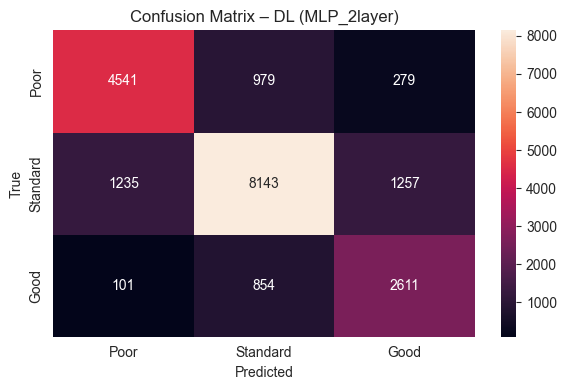

In [44]:
labels_order = ["Poor", "Standard", "Good"]

cm = confusion_matrix(y_val, best_preds, labels=labels_order)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels_order,
    yticklabels=labels_order
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – DL ({best_dl})")
plt.tight_layout()
plt.show()

Macierz pomyłek wskazuje, że najczęstsze błędy klasyfikacji
polegają na myleniu klas sąsiednich jakościowo,
tj. **Good ↔ Standard** oraz **Poor ↔ Standard**.

Błędy skrajne (np. klasyfikacja „Good” jako „Poor”) występują relatywnie rzadko,
co sugeruje, że model dobrze zachowuje porządek jakościowy klas.

In [49]:
acc = accuracy_score(y_val, best_preds)
print("Accuracy:", round(acc, 4))

Accuracy: 0.7648


Dodatkowo obliczono metrykę **accuracy**, która informuje o ogólnym
odsetku poprawnych predykcji modelu.

Należy jednak podkreślić, że ze względu na **niezbalansowany rozkład klas**
metryka accuracy może faworyzować klasy dominujące.
Dlatego w całej analizie jako główną miarę jakości
wykorzystywano **macro F1-score**, który traktuje wszystkie klasy równorzędnie.

### Deep Learning vs klasyczne modele ML

Pomimo zastosowania modeli Deep Learning,
najlepszy model MLP nie przewyższył jakościowo
strojenego modelu Random Forest,
który osiągnął wyższy macro F1-score.

Wskazuje to, że dla danych tablicowych
o dużej liczbie cech po kodowaniu One-Hot
modele drzewiaste mogą być bardziej efektywne
niż klasyczne sieci neuronowe MLP.

In [50]:
best_pipe_dl = dl_pipelines[best_dl]
joblib.dump(best_pipe_dl, "../models/best_dl_pipeline.joblib")

['../models/best_dl_pipeline.joblib']

In [51]:
model_info = {
    "model": f"MLPClassifier ({best_dl}, Pipeline)",
    "val_macro_f1": f1_score(y_val, best_preds, average="macro"),
    "val_accuracy": accuracy_score(y_val, best_preds)
}

with open("../models/best_dl_metadata.json", "w") as f:
    json.dump(model_info, f, indent=4)

## Podsumowanie etapu Deep Learning

W ramach tego etapu przetestowano kilka architektur modeli MLP różniących się liczbą i głębokością warstw ukrytych. Najlepszy wynik uzyskał model z dwiema warstwami ukrytymi (**MLP_2layer**, macro F1-score ≈ 0.75), jednak nie przewyższył on jakości najlepszego modelu klasycznego – strojonego **Random Forest**, który osiągnął wyższy macro F1-score.

Analiza wyników wskazuje, że dla danych tablicowych o wysokiej wymiarowości po kodowaniu One-Hot modele drzewiaste mogą być bardziej efektywne niż klasyczne sieci neuronowe MLP. Jednocześnie model MLP osiąga stabilne i sensowne rezultaty, co potwierdza, że sieci neuronowe mogą poprawnie uczyć się relacji w danych tego typu, choć bez wyraźnej przewagi jakościowej.

W kolejnym etapie projektu (**XAI – SHAP**) przeprowadzona zostanie **interpretacja obu najlepszych modeli**:
- najlepszego modelu klasycznego (**Random Forest**),
- najlepszego modelu Deep Learning (**MLP_2layer**).

Pozwoli to porównać nie tylko jakość predykcji, ale również **charakter i spójność wyjaśnień modelowych** dla dwóch różnych podejść do problemu klasyfikacji Credit Score.